# Champagne dataset with Holt-Winters model

For real-world exercise on forecasting with a time series, you will use the Champagne dataset, which lists the sales price in millions per month for Perrin Freres champagne, from 1964 to 1972.

Explore the data then build a Holt-Winters forecasting model, and use the walk-forward validation process to find the optimum model parameters (`ExponentialSmoothing()`).

You can choose the performance metric used to assess the model, i.e. other than MSE, for example the R-Squared metric.

NOTE: If you want to check the CSV dataset before loading with Pandas, use the `!head` command followed by the filepath to the CSV file.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

%matplotlib inline

In [4]:
df = pd.read_csv('data/perrin-freres-monthly-champagne.csv', index_col='Month', engine='python', skipfooter=2, parse_dates=True)

In [5]:
df.head()

,Perrin Freres monthly champagne sales millions ?64-?72
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [7]:
df.columns = ['sales']

In [8]:
df.head()

,sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [9]:
# Nearly 9 years of data

df.shape

(105, 1)

In [42]:
df.isnull().sum()

sales                  0
Holt-Winters_train    12
Holt-Winters_test     93
dtype: int64

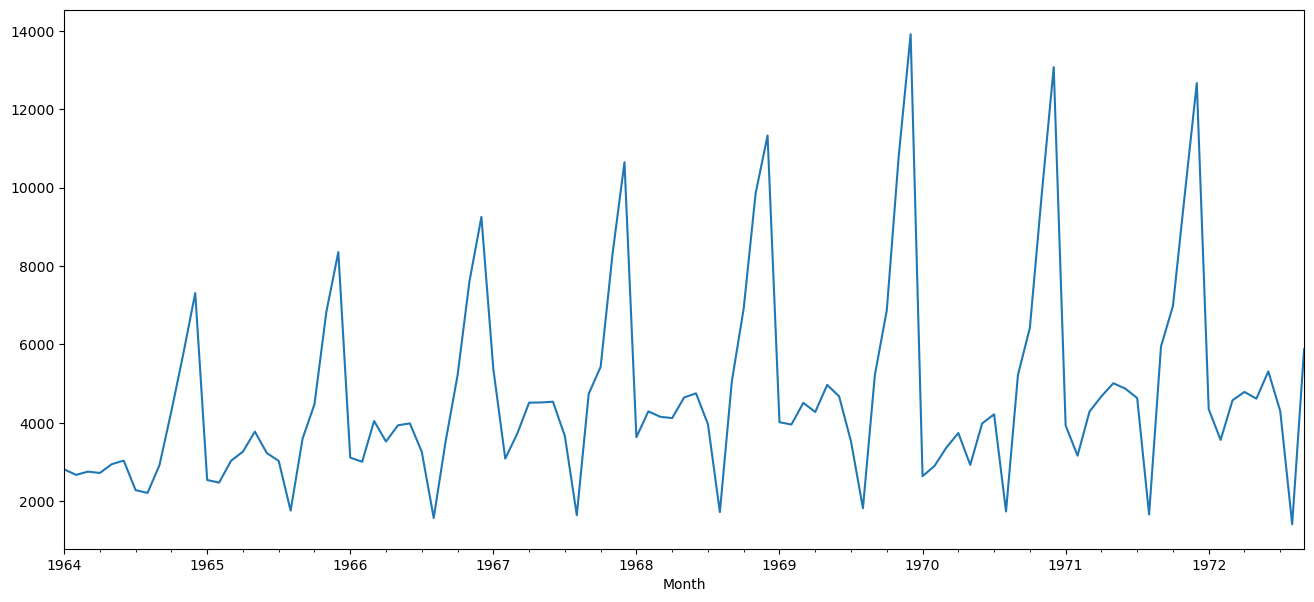

In [13]:
df['sales'].plot(figsize=(16, 7));

**The time series stays relatively stationary, i.e. constant mean and variance, with a slight trend but predominantly there are regular large spikes at the end of each year, which indicates seasonality, e.g. Christmas period means at least triple the regular sales numbers. Also, notice that the seasonality increases in amplitude over time, at least until 1970.** 

## Build Holt-Winters model

In [14]:
# Set index frequency to start of every month

df.index.freq = 'MS'

In [15]:
# Create training and test sets

N_test = 12

train = df.iloc[: -N_test]
test = df.iloc[-N_test :]

In [16]:
# Boolean index the time series to index df rows

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [18]:
# Start with additive combinations of trend and seasonality

hw = ExponentialSmoothing(train['sales'], 
                          initialization_method='legacy-heuristic', 
                          trend='add', 
                          seasonal='add', 
                          seasonal_periods=12)

res_hw = hw.fit()

In [19]:
df.loc[train_idx, 'Holt-Winters_train'] = res_hw.fittedvalues

In [20]:
df.loc[test_idx, 'Holt-Winters_test'] = res_hw.forecast(N_test)

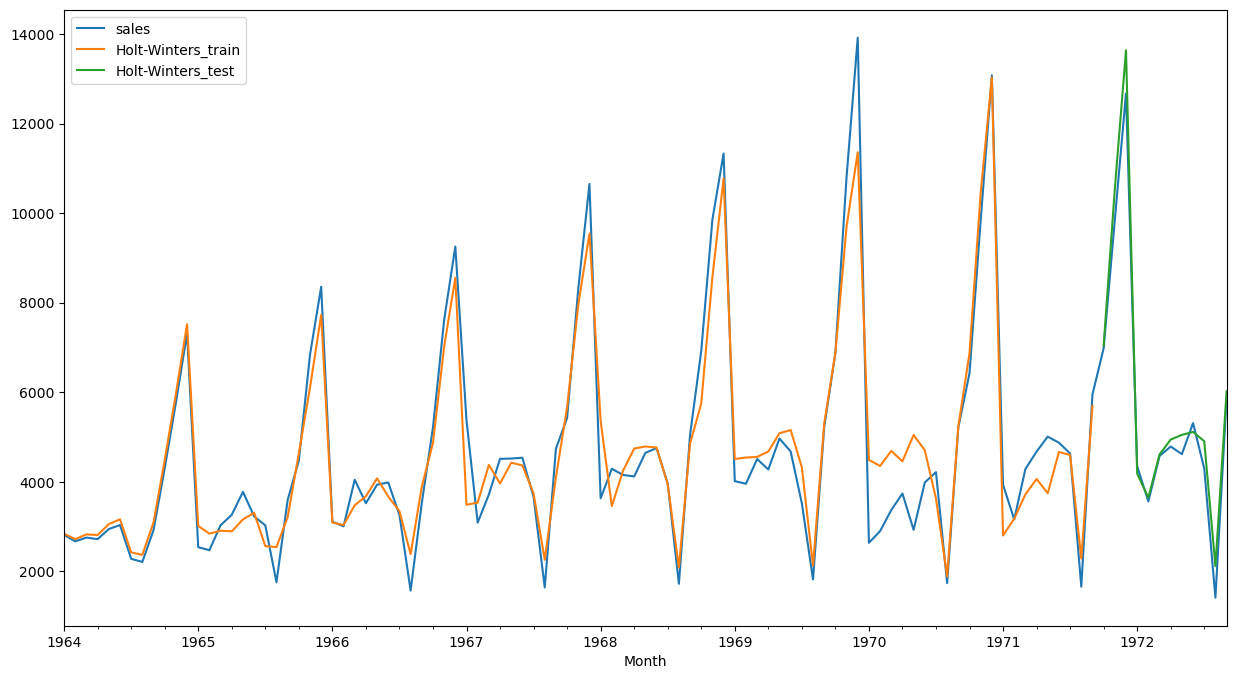

In [21]:
df[['sales', 'Holt-Winters_train', 'Holt-Winters_test']].plot(figsize=(15, 8));

**The model predictions appears to have captured the seasonality fairly well, and increase steadily over time. This indicates the model is reaonable fit for the data, but you can confirm with performance metrics in SciKit-Learn.**

In [22]:
r2_score(train['sales'], res_hw.fittedvalues)

0.9173433418354158

In [23]:
r2_score(test['sales'], res_hw.forecast(N_test))

0.9735679986862097

**Interestingly, the model has performed extremely well on the test set - better than the training set, which is unusual. It seems that the model has a harder time predicting the peaks in the data, confirmed by the plot above. You can try other options using the Walk-Forward validation process.**

## Walk-Forward Validation

The forecast horizon is best kept the same, i.e. a year cycle. To calculate the number of rows in the validation set, make sure that the remaining value is divisible by 6:

    105 - 12 - 6 = 87, i.e. test set is 18 rows

In [32]:
# Forecast horizon is 12 steps
h = 12

# No of 'walk-forward' timesteps
steps = 6

# Validation period - min size of training set
train_size = len(df) - h - steps + 1

In [33]:
train_size

88

In [34]:
# Configuration of possible model parameters

trend_type_list = ['add', 'mul']
seasonal_type_list = ['add', 'mul']
damped_trend_list = [True, False]
init_method_list = ['estimated', 'heuristic', 'legacy-heuristic']
use_boxcox_list = [True, False, 0]

In [35]:
from sklearn.metrics import mean_squared_error

In [36]:
def walkforward(trend_type, seasonal_type, damped_trend, init_method, use_boxcox, debug=False):
    # Store errors 
    errors = [] 
    # All rows processed?
    seen_last = False 
    # No of steps completed (should be 10)
    steps_completed = 0
    
    for end_of_train in range(train_size, len(df) - h + 1):
        # No need to manually 'add' data to dataset, just index it at the right points - it is a "view" not a "copy" 
        # (so it doesn't take up any extra space or computation) 
        train = df.iloc[:end_of_train] 
        test = df.iloc[end_of_train:end_of_train + h] 
        
        # For debugging
        if test.index[-1] == df.index[-1]:
            seen_last = True
        
        # Increment walk-forward by 1
        steps_completed += 1
        
        # Instantiate model
        hw = ExponentialSmoothing(df['sales'], 
                                  initialization_method=init_method, 
                                  trend=trend_type, 
                                  damped_trend=damped_trend,
                                  seasonal=seasonal_type,
                                  seasonal_periods=12,
                                  use_boxcox=use_boxcox) 
        
        # Train model
        res_hw = hw.fit()
        
        # Compute error for the forecast horizon 
        fcast = res_hw.forecast(h) 
        error = mean_squared_error(test['sales'], fcast) 
        errors.append(error)
    
    # Check debug flag
    if debug:
        print("seen_last:", seen_last) 
        print("steps completed:", steps_completed)
        
    return np.mean(errors)

In [37]:
# Test function

walkforward('add', 'add', False, 'legacy-heuristic', 0, debug=True)

seen_last: True
steps completed: 6


14603776.652314484

In [38]:
print("RMSE score:", np.sqrt(14603776.652314484))

RMSE score: 3821.488800495755


In [39]:
tuple_of_option_lists = (trend_type_list, seasonal_type_list, damped_trend_list, init_method_list, use_boxcox_list)

In [41]:
# Some warnings about 'overflow' and NaN values indicate a bad model that has been rejected or failed
import itertools

best_score = float('inf')
best_options = None

for x in itertools.product(*tuple_of_option_lists):
    score = walkforward(*x) 
    
    if score < best_score:
        print("Best score so far:", score) 
        best_score = score 
        best_options = x

Best score so far: 15212463.505993402


C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

Best score so far: 15024120.128990682
Best score so far: 14391918.989312597


C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

Best score so far: 14059823.245871963


C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

Best score so far: 14051691.169405527


C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to co

ValueError: Input contains NaN.

In [43]:
print("Best score:", best_score)

Best score: 14051691.169405527


In [44]:
trend_type, seasonal_type, damped_trend, init_method, use_boxcox = best_options

print("Best model parameters:\n")
print("trend:", trend_type)
print("seasonal:", seasonal_type)
print("damped_trend:", damped_trend)
print("initialization_method:", init_method)
print("use_boxcox:", use_boxcox)

Best model parameters:

trend: add
seasonal: mul
damped_trend: True
initialization_method: legacy-heuristic
use_boxcox: True


In [45]:
Ntest = 12

train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [46]:
hw = ExponentialSmoothing(train['sales'], 
                          initialization_method='legacy-heuristic', 
                          trend='add', 
                          damped_trend=True, 
                          seasonal='mul',
                          seasonal_periods=12,
                          use_boxcox=True)

res_hw = hw.fit()

In [47]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [48]:
df.loc[train_idx, 'train_preds'] = res_hw.fittedvalues
df.loc[test_idx, 'forecast'] = res_hw.forecast(Ntest)

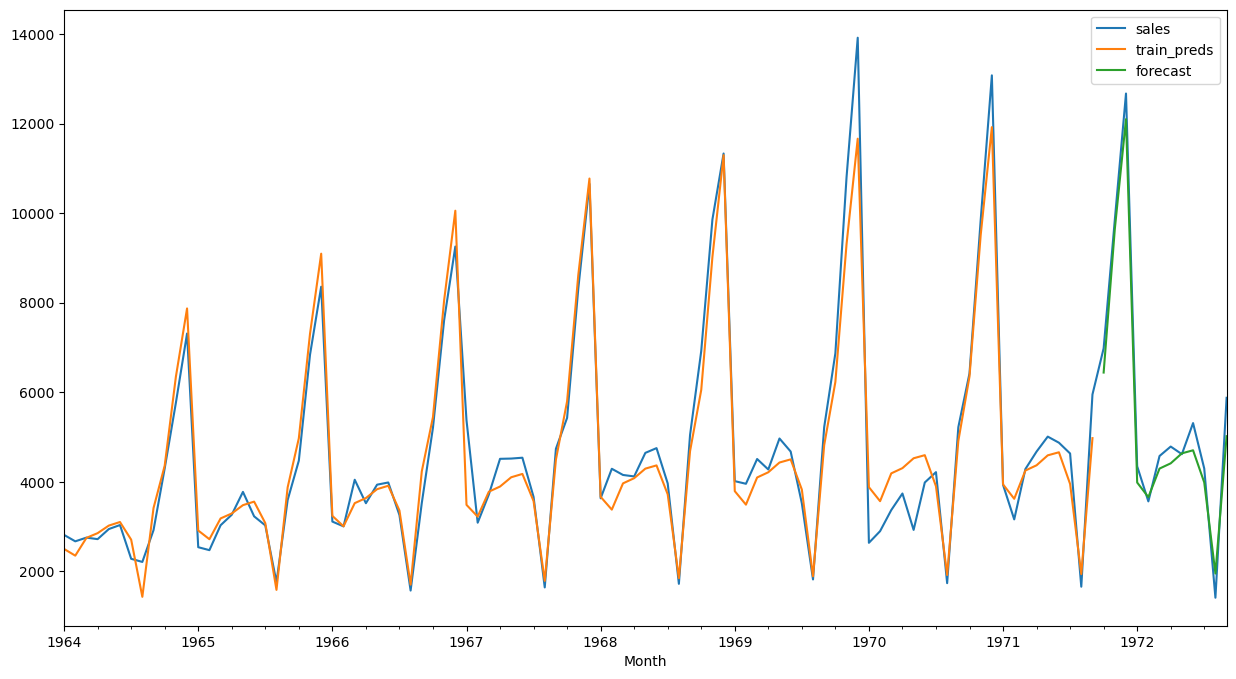

In [49]:
df[['sales', 'train_preds', 'forecast']].plot(figsize=(15, 8));

**The forecasted values now fit the time series very well, although the training set is still struggling to cope with the seasonality levels. This model, however, seems to 'generalize' better to the out-of-sample data when seasonality is multiplicative and there is a dampened trend effect. Additionally, model prefers values to be passed through Box-Cox transformation.**

In [50]:
r2_score(train['sales'], res_hw.fittedvalues)

0.945546877739527

In [51]:
r2_score(test['sales'], res_hw.forecast(Ntest))

0.9742398553679308